In [1]:
def read_file(filepath):
    tags=[]
    sentence_tags = []
    sentences = []
    sentence = []
    for line in open(filepath, encoding='utf-8'):
        if line !='\n':
            word, tag = line.strip().split()
            if word.startswith('http://') or word.startswith('https://'):
                word = '<URL>'
            if word.startswith('@'):
                word = '<USR>'
            sentence.append(word)
            sentence_tags.append(tag)
        if line == '\n':
            sentences.append(sentence)
            tags.append(sentence_tags)
            sentence = []
            sentence_tags = []
    return sentences, tags

In [2]:
sents, tags = read_file('data/train.txt')

In [3]:
len(sents)

5795

In [4]:
len(tags)

5795

In [5]:
for word, tag in zip(sents[1], tags[1]):
    print(f"{word} ----> {tag}")

Apple ----> B-product
MacBook ----> I-product
Pro ----> I-product
A1278 ----> I-product
13.3 ----> I-product
" ----> I-product
Laptop ----> I-product
- ----> I-product
MD101LL/A ----> I-product
( ----> O
June ----> O
, ----> O
2012 ----> O
) ----> O
- ----> O
Full ----> O
read ----> O
by ----> O
eBay ----> B-company
<URL> ----> O
<URL> ----> O


In [6]:
from keras.preprocessing.text import Tokenizer

tweet_words_tokenizer = Tokenizer(lower=False, oov_token='<UNK>')
tweet_words_tokenizer.fit_on_texts(sents)

Using TensorFlow backend.


In [7]:
from collections import defaultdict

len_dict = defaultdict(int)
for sent in sents:
    len_dict[len(sent)]+=1


In [8]:
import matplotlib.pyplot as plt

In [12]:
lens_, counts_ = [], []
for len_, count_ in len_dict.items():
        lens_.append(len_)
        counts_.append(count_)

<BarContainer object of 40 artists>

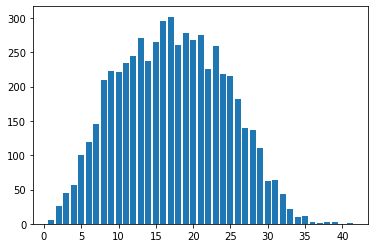

In [15]:
plt.bar(lens_, counts_)

In [18]:
max(lens_)

41

In [19]:
len_dict[41]

1

In [20]:
sequences = tweet_words_tokenizer.texts_to_sequences(sents)

In [22]:
# assuming max len as 40
from keras.preprocessing.sequence import pad_sequences
padded_sequences = pad_sequences(sequences, padding='post', maxlen=40)


In [26]:
tag_tokenizer = Tokenizer(lower=False,)
tag_tokenizer.fit_on_texts(tags)
tag_sequences = tag_tokenizer.texts_to_sequences(tags)

In [37]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Embedding, Dropout
from keras.layers import TimeDistributed, Bidirectional

In [82]:
vocab_size = len(tweet_words_tokenizer.word_index)
num_classes = len(tag_tokenizer.word_index)

In [85]:
model = Sequential()
model.add(Embedding(vocab_size+1, 256, mask_zero=True, input_length=40 ))
model.add(Dropout(0.1))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(TimeDistributed(Dense(num_classes, activation='softmax')))

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")

In [63]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 40, 256)           4857344   
_________________________________________________________________
dropout_5 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 64)            73984     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 40, 21)            1365      
Total params: 4,932,693
Trainable params: 4,932,693
Non-trainable params: 0
_________________________________________________________________


In [43]:
import numpy as np
y_arr = np.array(tag_sequences)

In [51]:
tag_tokenizer.word_index['O']

1

In [57]:
y_arr_padded = pad_sequences(tag_sequences, padding='post', maxlen=40, value=0)

In [58]:
y_arr_padded

array([[ 1,  1,  1, ...,  0,  0,  0],
       [10,  7,  7, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       ...,
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0],
       [ 1,  1,  1, ...,  0,  0,  0]])

In [65]:
y_arr = y_arr_padded.reshape(-1, 40, 1)

In [66]:
y_arr.shape

(5795, 40, 1)

In [69]:
tag_tokenizer.word_index

{'O': 1,
 'B-geo-loc': 2,
 'B-person': 3,
 'I-other': 4,
 'B-other': 5,
 'B-company': 6,
 'I-product': 7,
 'I-person': 8,
 'I-facility': 9,
 'B-product': 10,
 'B-facility': 11,
 'B-musicartist': 12,
 'I-geo-loc': 13,
 'I-company': 14,
 'B-sportsteam': 15,
 'I-musicartist': 16,
 'I-movie': 17,
 'I-sportsteam': 18,
 'B-movie': 19,
 'B-tvshow': 20,
 'I-tvshow': 21}

In [71]:
for key in tag_tokenizer.word_index:
    tag_tokenizer.word_index[key]-=1

In [73]:
tag_tokenizer.word_index['PAD'] = 21

In [74]:
tag_sequences = tag_tokenizer.texts_to_sequences(tags)
y_arr_padded = pad_sequences(tag_sequences, padding='post', maxlen=40, value=21)
y_arr = y_arr_padded.reshape(-1, 40, 1)

In [78]:
len(tag_tokenizer.word_index)

22

In [80]:
y_arr.shape

(5795, 40, 1)

In [86]:
model.fit(padded_sequences, y_arr)

Epoch 1/1
5795/5795 [==============================] - 27s 5ms/step - loss: 0.8095


In [87]:
history = model.fit(padded_sequences, y_arr, epochs=15)

Epoch 1/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.3487
Epoch 2/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.2688
Epoch 3/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.2339
Epoch 4/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.2005
Epoch 5/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.1568
Epoch 6/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.1114
Epoch 7/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.0784
Epoch 8/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.0554
Epoch 9/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.0390
Epoch 10/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.0280
Epoch 11/15
5795/5795 [==============================] - 24s 4ms/step - loss: 0.0202
Epoch 12/15
5795/5795 [==============================] - 23s 4ms/step - lo

In [91]:
model.predict_classes(padded_sequences[1].reshape(1,-1))

array([[9, 6, 6, 6, 6, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int64)

In [96]:
classes = model.predict_classes(padded_sequences[1].reshape(1,-1))

In [97]:
tag_tokenizer.sequences_to_texts(classes)

['I-facility B-company B-company B-company B-company B-company B-company B-company B-company']

In [101]:
tweet_words_tokenizer.sequences_to_texts(padded_sequences[1].reshape(1,-1))

['Apple MacBook Pro A1278 13.3 " Laptop - MD101LL/A ( June , 2012 ) - Full read by eBay <URL> <URL> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>']

In [109]:
tag_tokenizer.sequences_to_texts([tag_sequences[1]])

['I-facility B-company B-company B-company B-company B-company B-company B-company B-company B-other']

In [114]:
senten = []
for index in tag_sequences[1]:
    senten.append(tag_tokenizer.index_word[index])
print(' '.join(senten))

KeyError: 0

In [115]:
tag_tokenizer.index_word

{1: 'O',
 2: 'B-geo-loc',
 3: 'B-person',
 4: 'I-other',
 5: 'B-other',
 6: 'B-company',
 7: 'I-product',
 8: 'I-person',
 9: 'I-facility',
 10: 'B-product',
 11: 'B-facility',
 12: 'B-musicartist',
 13: 'I-geo-loc',
 14: 'I-company',
 15: 'B-sportsteam',
 16: 'I-musicartist',
 17: 'I-movie',
 18: 'I-sportsteam',
 19: 'B-movie',
 20: 'B-tvshow',
 21: 'I-tvshow'}

In [116]:
tag_tokenizer.word_docs

defaultdict(int,
            {'B-musicartist': 180,
             'O': 5795,
             'I-musicartist': 110,
             'B-company': 493,
             'I-product': 169,
             'B-product': 254,
             'B-person': 671,
             'B-other': 669,
             'I-other': 362,
             'I-facility': 240,
             'B-facility': 291,
             'B-sportsteam': 142,
             'B-geo-loc': 771,
             'I-geo-loc': 191,
             'I-company': 139,
             'B-movie': 55,
             'I-movie': 44,
             'I-person': 358,
             'I-tvshow': 32,
             'B-tvshow': 57,
             'I-sportsteam': 43})

In [119]:
keys = list(tag_tokenizer.word_docs.keys())

In [120]:
values = list(tag_tokenizer.word_docs.values())

In [123]:
keys.remove('O')

In [124]:
values.remove(5795)

<BarContainer object of 20 artists>

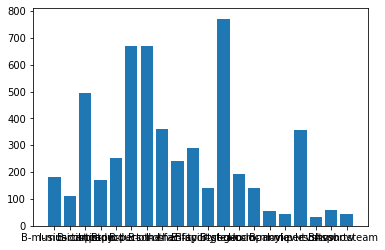

In [125]:
plt.bar(keys, values)